In [17]:
# pip install imageio[ffmpeg]
# pip install opencv-python

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as cst
import astropy.units as u
import imageio
import scipy as sp
import matplotlib.image as mpimg
import matplotlib.patches as patches
from skimage import io, color
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file
import astropy.coordinates as coord
import astropy.units as u
import astropy.constants as cst
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

# Lensing Functions

In [18]:


def lens_to_source_plane(theta, mass, D_L, D_LS):
    '''
    Maps the position of rays on the lens plane to the source plane.

    Inputs: theta (angular position of rays on lens plane relative to the observer),
    mass (mass of the black hole), D_L (distance from observer to the lens plane) and D_LS (distance of the source plane
    relative to the lens plane)

    Returns: theta*(1 - (4*cst.G*mass)/(cst.c**2*D_L * sep**2) * (D_LS/D_L)) (Angular position of the rays on the source plane relative to the observer.)
    '''
    # Normalise theta.

    sep = np.linalg.norm(theta, axis=0).to(u.rad).value
    return theta*(1 - (4*cst.G*mass)/(cst.c**2*D_L * sep**2) * (D_LS/D_L))

def obtain_grids(img, M_lens = 1*u.M_sun, D_os = 8*u.kpc, D_ol = 4*u.kpc, src_pos = (0,0)):
  '''
    Obtains the x, y coordinates in the form of meshgrids for the pixels
    on the lensed image and the source image.

    Inputs: img (the source image), M_lens (mass of the gravitational lens),
    D_os (Distance of the source relative to the observer), src_pos (position of the lensing source),
    x_axis (sets the bounds for the x_axis) and y_axis (sets the bounds for the y_axis).

    Returns: xl, yl, xs, ys (x,y coordinates represented as meshgrids for pixels on the lensed image (xl, yl)
    and the source image (xs, ys)).
    '''
  # Find the distance of the source plane relative to the lens plane.
  D_ls = D_os - D_ol

  # Obtain the dimensions of the image.
  height = img.shape[0]
  width = img.shape[1]

  # Obtain corresponding x and y meshgrids which represent x and y coordinates
  # of the lens plane.
  x = src_pos[0]
  y = src_pos[1]
  rngx = np.linspace(0-x,360-x,width)
  rngy = np.linspace(-90-y,90-y,height)
  xv, yv = np.meshgrid(rngx,rngy)*u.mas


  # Map the x, y coordinates in the lens plane to the source plane.
  xs, ys = lens_to_source_plane(np.array([xv, yv])*u.mas, M_lens, D_ol, D_ls).to(u.mas)
  return xv, yv, xs, ys

def transform_img(xs,ys,xv,yv,img):
  '''
  Input the lens to source transformed meshgrids (xs,ys) and the original
  meshgrids (xv, yv).
  Returns the transformed image
  '''

  # Obtain a grid of relevant column indices for final image.
  rowsx, colsx = xs.shape
  x_idx = np.ones(img.shape)
  for ix in range(rowsx):
    for jx in range(colsx):
      valx = xs[ix,jx]
      diff_abx = abs(xv[0,:]-valx)
      x_idx[ix,jx] = np.argmin(diff_abx)

  # Obtain a grid of relevant row indices for final image.
  rowsy,colsy = ys.shape
  y_idx = np.ones(img.shape)
  for iy in range(rowsy):
    for jy in range(colsy):
      valy = ys[iy,jy]
      diff_aby = abs(yv[:,0]-valy)
      y_idx[iy,jy] = np.argmin(diff_aby)

  # Map pixels from original image to the final image.
  new_im = np.ones(img.shape)
  rows,cols = img.shape
  for row in range(rows):
    for col in range(cols):
      new_im[row,col] = img[int(y_idx[row,col]),int(x_idx[row,col])]

  return new_im

# Read Data

In [19]:
# Read csv to data frame
data = pd.read_csv('kicked_remnants_igoshev_young_7.8_DC_final.csv')

# Filter out neutron stars
df = data[data['rtype']  == 'Black Hole']

# Solar mass, vR, vT, phi, will_escape is rtype 
unique_values = df['rtype'].unique()

# Check that neutron stars are gone 
print(f"Check filter worked, unique in rtype: {unique_values}\n")

arrayvals = [-8.3, 4.5]
posx = data['px'].tolist()
posy = data['py'].tolist()
posz = data['pz'].tolist()
velx = data['vx'].tolist()
vely = data['vy'].tolist()
velz = data['vz'].tolist()
smass = np.array(data['smass'].tolist()) # This needs to be converted to be filtered later
dataGal = coord.SkyCoord(x=posx* u.kpc,
                   y=posy * u.kpc,
                   z=posz* u.kpc,
                   v_x=velx* u.km / u.s,
                   v_y=vely* u.km / u.s,
                   v_z=velz* u.km / u.s,
                   frame=coord.Galactocentric)


dataICRS = dataGal.transform_to(coord.ICRS) # Variable name remains the same


Check filter worked, unique in rtype: ['Black Hole']



# Run (Generate Video)

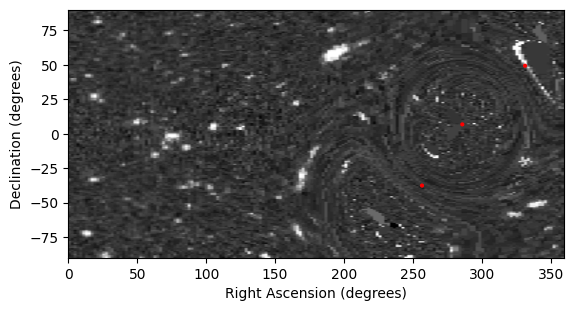

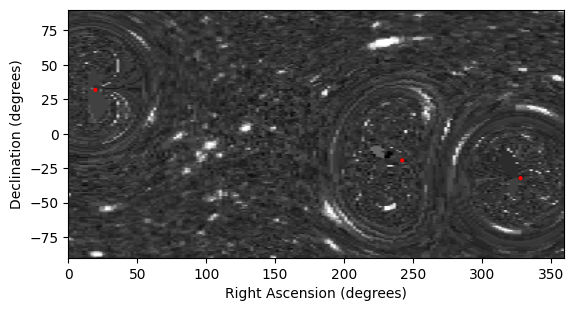

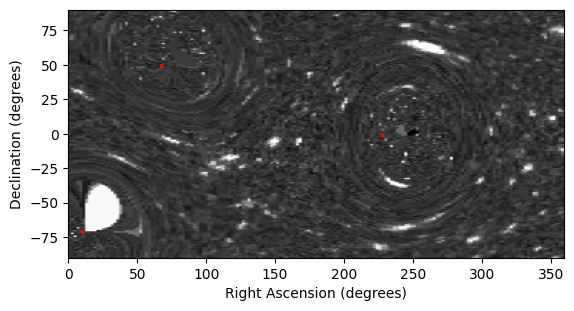

Video created successfully.


In [ ]:

"""LOAD IMAGE
"""
img = mpimg.imread("LSST-image.png")

# Stack multiple images
# img = np.hstack((img, img))

# Added: make 2D 
img = img[:,:,0]


"""SLICE SECTION OF IMAGE
- Slices a section of image. Useful to reduce running time for testing. 
"""
# Get image dimensions (height, width)
img_height, img_width = img.shape

# Define the fractional region you want to cut out
x_frac_start, y_frac_start = 0.1, 0.2  # Starting fraction (top-left corner of the section)
width_frac, height_frac = 0.2, 0.2     # Width and height fraction of the section

# Convert fractions to pixel values
x_start = int(x_frac_start * img_width)
y_start = int(y_frac_start * img_height)
width = int(width_frac * img_width)
height = int(height_frac * img_height)

# Slice the image to get the desired section
img = img[y_start:y_start + height, x_start:x_start + width]


"""SELECT SET OF BH TO PLOT
- Sets filters based on centre and width (degrees) of the chosen image. For plotting all BHs within the image. 
""" 

# Boundaries of LSST image
ra_start = 0
dec_centre = 0
ra_len = 360
dec_len = 180
ra_bounds = [ra_start, ra_start+ra_len]
dec_bounds = [dec_centre-dec_len/2, dec_centre+dec_len/2]
filter_x =  (dataICRS.ra.deg > ra_bounds[0]) & (dataICRS.ra.deg < ra_bounds[1]) 
filter_y =  (dataICRS.dec.deg > dec_bounds[0]) & (dataICRS.dec.deg < dec_bounds[1]) 
smass2 = smass[(filter_x)&(filter_y)]
x = dataICRS.ra.deg[(filter_x)&(filter_y)]
y = dataICRS.dec.deg[(filter_x)&(filter_y)]
d = dataICRS.distance.kpc[(filter_x)&(filter_y)]
vRa = (dataICRS.pm_ra_cosdec*u.mas/u.yr)[(filter_x)&(filter_y)] 
vDc = (dataICRS.pm_dec*u.mas/u.yr)[(filter_x)&(filter_y)]
vrad = (dataICRS.radial_velocity*u.m/u.s)[(filter_x)&(filter_y)] 
# vRa = (dataICRS.pm_ra_cosdec*u.mas/u.yr)[(filter_x)&(filter_y)]/3.6e6
# vDc = (dataICRS.pm_dec*u.mas/u.yr)[(filter_x)&(filter_y)]/3.6e6
# vrad = (dataICRS.radial_velocity*u.m/u.s)[(filter_x)&(filter_y)]/31536 # Convert to km/year  



"""INITIALIZE LOOP 
- Set the number of BH to place (if more than one have been filtered from the data set)
- Lists to store frames and video frames 
- Original image 
"""

# Limit the number of BHs to place 
num_2_place = 3

# Set the number of frames
num_frame = 3

# Set the frame rate (fps)
fps = 5


# Update positions 
frames = []
vidframes = []


img_original = img


for j in range(num_frame):

    fig, ax = plt.subplots()

    img = img_original

    for i in range(num_2_place):
        xcoord = x[i]
        ycoord = y[i]
        dist = d[i]
        mass = smass2[i]

        """GENERATE MESHGRID
        - obtain_grids: meshgrid placement assumes ra and dec corresponding to full sky. src_pos receives -ycoord. 
        - First line: mass scaled up and default 4kpc
        - Second line: able to include correct masses and distances. 
        """
        # Obtain relevant meshgrids
        xv, yv, xs, ys = obtain_grids(img, M_lens = 1000*u.M_sun, src_pos=(xcoord,-ycoord)) # Scaled up and D_ol = 4kpc default
        # xv, yv, xs, ys = obtain_grids(img, M_lens = mass*u.M_sun, src_pos=(xcoord,-ycoord), D_ol=dist*u.kpc) 

        """LENS IMAGE
        - This function transforms the image and returns the new one
        """
        # Obtain transformed image
        new_im = transform_img(xs,ys,xv,yv, img)


        """MARKERS FOR TESTING
        - Mark expected position with red dot
        """
        # red_dot = patches.Circle((xcoord, ycoord), radius=size, color=col)
        red_dot = patches.Circle((xcoord, ycoord), radius=1, color='red')
        ax.add_patch(red_dot)s

        """RESET IMAGE
        - Make the lensed image the new background, to be lensed by another BH. Assumes lensing effects of adjacent BHs will not impact each other. 
        """
        img = new_im
    
    
    """SAVING FRAMES
    """
    ax.imshow(new_im, extent=[ra_bounds[0], ra_bounds[1], dec_bounds[0], dec_bounds[1]], aspect='equal', cmap='gray')
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)') 
    frames.append(fig)


    # Convert the Matplotlib plot to an image array
    fig.canvas.draw() # render the image on the canvas, making it possible to access the pixel data.
    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8') # Convert data to numpy array
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    vidframes.append(image_array)

    """MOVE BHs
    - incrament positions based on velocities
    - Keep BH within image if they move outside RA = [0,360] or DEC = [-90,90]
    """
    # Incrament 
    x += vRa.value
    y += vDc.value
    d += vrad.value

    # Keep x in the range [0, 360) for all elements
    x = x % 360

    # Keep y in the range [-90, 90] for all elements
    y = np.where(y > 90, 180 - y, y)
    y = np.where(y < -90, -180 - y, y)



for fig in frames:
    plt.show(fig)


### Save the frames as a video
name = f"bh_warp_3Nov.mp4"


# 1 frame persecond 
imageio.mimsave(name, vidframes, fps=fps)
print("Video created successfully.")
